# <font color='red'>[Traversing Airbnb London Calendar & Listings](http://insideairbnb.com/get-the-data.html)</font>

Airbnb doesn't officially doesn't expose their data for detailed study, nor does subscribe to <span style="color:red">Inside Airbnb</span> which acts a tool to access relevant resources like reviews, calendars, listing and neighbourhoods for general investigational purposes. Let us begin by importing required libraries before jumping on to reading & wrangling their data. My choice of city is arbitrary, so feel free to follow the links attached to select your preferred Airbnb operational city.

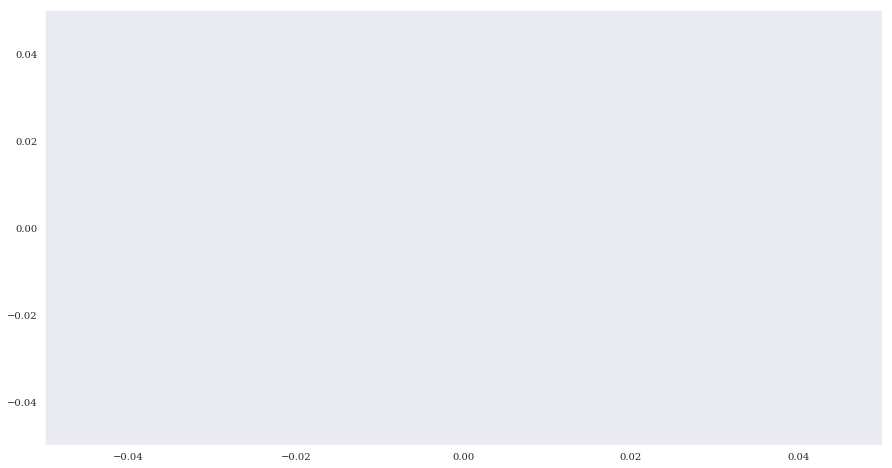

In [25]:
# Importing generic analysis Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting aesthetical parameters:
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['patch.force_edgecolor'] = True
plt.autoscale(enable=True, axis='both', tight=True)

# To ignore unnecessary warnings:
import warnings
warnings.filterwarnings('ignore')

# Libraries for data cleaning & modeling:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

## Loading Data:

In [2]:
listings = pd.read_csv('D:/CRITICAL/New_Desktop/listings.csv')
calendar = pd.read_csv('D:/CRITICAL/New_Desktop/calendar.csv')
reviews = pd.read_csv('D:/CRITICAL/New_Desktop/reviews.csv')

Now let us go through each of these data files one by one to gain a better understanding of how things have been fluctuating and what really we need to care about as those factors might be creating business imapct. Let's start:

## Exploring Listings Data:

Let us preview how this dataset actually looks like, shape, columns and other relevant information:

In [3]:
print(f"Listings dataset has {listings.shape[0]} rows and {listings.shape[1]} columns in it. /n List of first 25 columns include {list(listings.columns)[:20]}.")
listings.head()

Listings dataset has 78415 rows and 106 columns in it. /n List of first 25 columns include ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id'].


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9554,https://www.airbnb.com/rooms/9554,20190205040841,2019-02-05,"Cozy, 3 minutes to Piccadilly Line",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,"Hello people, This is a bright, comfortable ro...",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,none,Details to follow..,...,f,f,strict_14_with_grace_period,t,f,4,1,3,0,1.62
1,13913,https://www.airbnb.com/rooms/13913,20190205040841,2019-02-05,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.14
2,15400,https://www.airbnb.com/rooms/15400,20190205040841,2019-02-05,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.73
3,17402,https://www.airbnb.com/rooms/17402,20190205040841,2019-02-05,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,f,f,strict_14_with_grace_period,f,f,13,13,0,0,0.41
4,24328,https://www.airbnb.com/rooms/24328,20190205040841,2019-02-05,Battersea 2 bedroom house & parking,"Artist house, high ceiling bedrooms, private p...",- End of terrace two bedroom house close to So...,"Artist house, high ceiling bedrooms, private p...",family,"- Battersea is a quiet family area, easy acces...",...,f,f,moderate,t,t,1,1,0,0,0.92


In [4]:
listings.shape

(78415, 106)

So we have **<span style="color:green">78415 listings</span>** in this dataset, with **<span style="color:green">106 features</span>** in it. As it is a pretty big number, let us get unique counts from it:

In [5]:
listings['id'].nunique()

78415

Seems there is no repetition. That is good for us! Let us now focus on the neighbourhoods for which hosts have listed their house/apartments. This should direct our attention to the **neighbourhoods where Airbnb hosts are in majority**.

### Categorical Features:

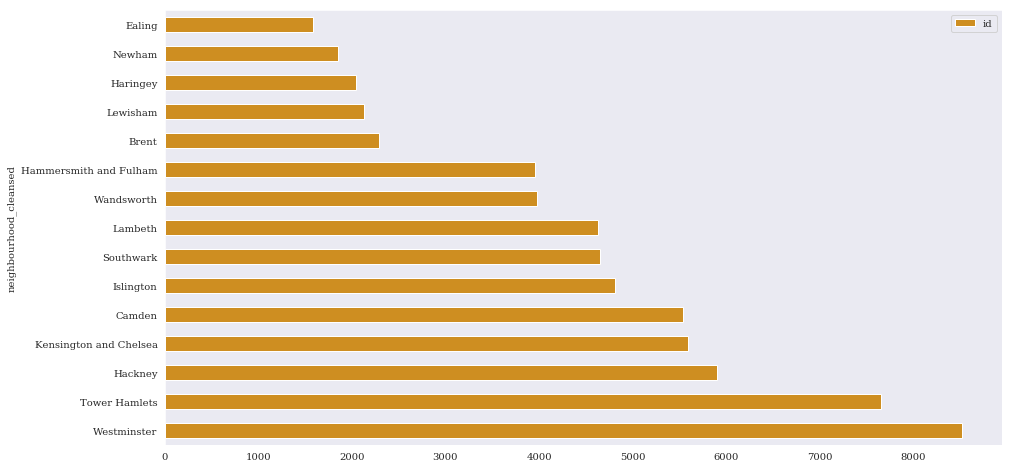

In [26]:
listings.groupby('neighbourhood_cleansed').count()[['id']].sort_values('id', ascending=False).head(15).plot(kind='barh', color='#ce8e21')

For people living in or around **<span style="color:green">London</span>**, *<span style="color:red">Westminster</span>* & *<span style="color:red">Tower Hamlets</span>* rising up for this won't really be a surprise because there are always strangers around in these areas.

Now let us understand variations in customer *review scoring*:

count    57424.000000
mean        92.674195
std          9.931074
min         20.000000
25%         90.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64


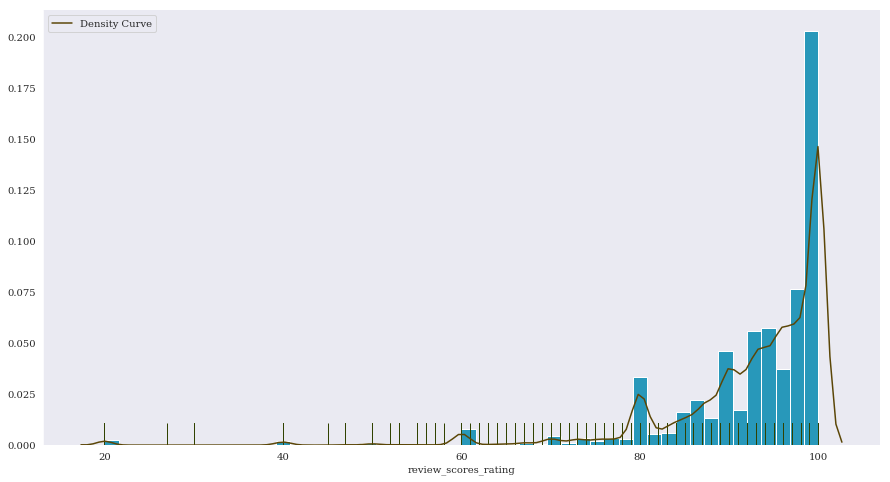

In [27]:
scores = listings['review_scores_rating'].dropna()

print(scores.describe())
sns.distplot(scores, rug=True, rug_kws={'color':'#314201'}, kde_kws={'color':'#5b4607','lw':1.5,'label':'Density Curve'}, 
             hist_kws={'alpha':1,'color':'#2898ba'})
sns.despine()
plt.show()

Well it looks like most people rate Airbnb services **<span style='color:green'>4</span>/<span style='color:green'>5</span>** out of **<span style='color:green'>5</span>**, always projecting at high end.

Ideally rates in London are generally high! So let us dig at the **<span style="color:green">pricing</span>** factor in these Listings.

In [8]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)

listings['price'].describe()

count    78415.000000
mean       113.656086
std        198.239243
min          0.000000
25%         45.000000
50%         80.000000
75%        130.000000
max      19000.000000
Name: price, dtype: float64

Let us find out what is so special about this costliest Airbnb listing!

In [9]:
listings[listings['price']==19000.0][['listing_url','host_picture_url','neighbourhood_cleansed','price']]

,listing_url,host_picture_url,neighbourhood_cleansed,price
27869,https://www.airbnb.com/rooms/16117109,https://a0.muscache.com/im/users/43935156/prof...,Islington,19000.0
46263,https://www.airbnb.com/rooms/22218699,https://a0.muscache.com/im/pictures/c04429e9-c...,Hammersmith and Fulham,19000.0


Someone aware of this neighbourhood and soaring property price would know why there is such a high value to this asset. This place is close to *The Modern Pantry Clerkenwell*, *The Jerusalem Tavern*, *Workshop Coffee Co.*, and *The Zetter Townhouse* so has quite a bit of relevance to price. Check out [Listing URL](https://www.airbnb.co.in/rooms/16117109?guests=1&adults=1) to find out more! Or if willing to dig deeper from this dataset, we may observe following:

In [10]:
listings.iloc[np.argmax(listings['price'])]

id                                                                                       16117109
listing_url                                                 https://www.airbnb.com/rooms/16117109
scrape_id                                                                          20190205040841
last_scraped                                                                           2019-02-05
name                                            Warehouse Clerkenwell 2 double beds + sofabed 501
summary                                         My place is close to The Modern Pantry Clerken...
space                                           Two Bedroom Penthouse Our two bedroom apartmen...
description                                     My place is close to The Modern Pantry Clerken...
experiences_offered                                                                          none
neighborhood_overview                                                                         NaN
notes               

For further analysis on impact of **<span style="color:green">price</span>** factor, which for most of us is always of utmost importance, let us first find out and then git rid of *<span style="color:red">Outliers</span>*:

In [40]:
listings.loc[listings['price'] == 0]['price'].count()

29

There is no point including these 29 listings with no price mentioned. Let us also get rid of listings that are below a certain amount, say $500.00 for this illustration:

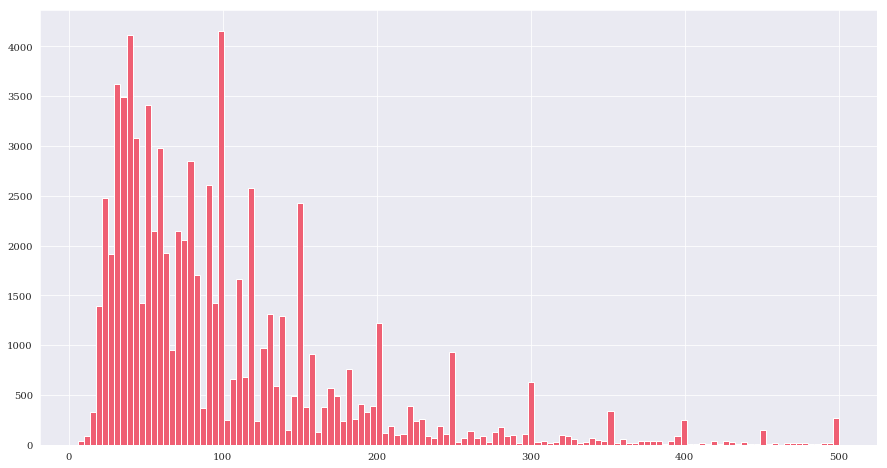

In [28]:
preferred_listing = listings.loc[(listings['price'] > 0) & (listings['price'] <= 500)]
preferred_listing.price.hist(bins=125, color='#ef5f73')

So our majority listing price chunk remains to be within $150.00. Hmmm!

As we discussed earlier, *neighbourhoods mostly has an impact on the listing price*. Remember how the costliest property owner boasted of her property surroundings to justify her pricing. Let's dig deeper into all of those listings:

In [13]:
# Take our previous range of listings (0 < Listing >= 500) & group DataFrame based on Neighbourhood.
# Then reselect the Price feature and pull the median price out of it.
# Finally based on Median value, sort out these neighbourhoods in descending order before indexing:
price_per_neighbourhood = preferred_listing.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
print(list(price_per_neighbourhood))

['City of London', 'Kensington and Chelsea', 'Westminster', 'Camden', 'Hammersmith and Fulham', 'Islington', 'Richmond upon Thames', 'Wandsworth', 'Southwark', 'Tower Hamlets', 'Lambeth', 'Hackney', 'Merton', 'Greenwich', 'Hounslow', 'Brent', 'Ealing', 'Newham', 'Barnet', 'Haringey', 'Waltham Forest', 'Kingston upon Thames', 'Enfield', 'Lewisham', 'Harrow', 'Bromley', 'Hillingdon', 'Havering', 'Sutton', 'Croydon', 'Redbridge', 'Barking and Dagenham', 'Bexley']


Now let us plot **<span style="color:green">Neighbourhood against Price</span>** using our derived data:

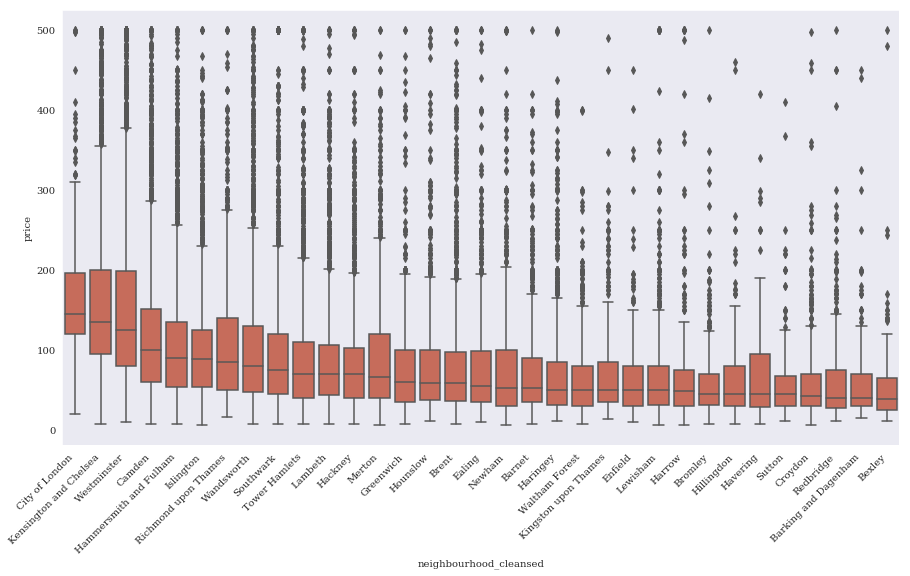

In [29]:
sns.boxplot(x='neighbourhood_cleansed', y='price', data=preferred_listing, order=price_per_neighbourhood, color='#d86049')

# Rotating X-axis labels:
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

A very intuitive difference can be observed in the *<span style="color:green">Median listing price</span>* where **London City** enjoys the highest and **Bexley** upset being lowest. Though pretty fair distribution based on geography.

How about the **Property Type**? Let's explore if that creates an impact!

In [15]:
listings.property_type.value_counts()

Apartment                        52976
House                            15977
Townhouse                         2930
Serviced apartment                2229
Condominium                        901
Bed and breakfast                  895
Loft                               732
Guest suite                        314
Guesthouse                         256
Other                              225
Hostel                             182
Boutique hotel                     168
Bungalow                           121
Hotel                              105
Cottage                             88
Boat                                54
Aparthotel                          52
Villa                               32
Tiny house                          32
Cabin                               27
Houseboat                           23
Camper/RV                           19
Casa particular (Cuba)              19
Earth house                         11
Chalet                               9
Barn                     

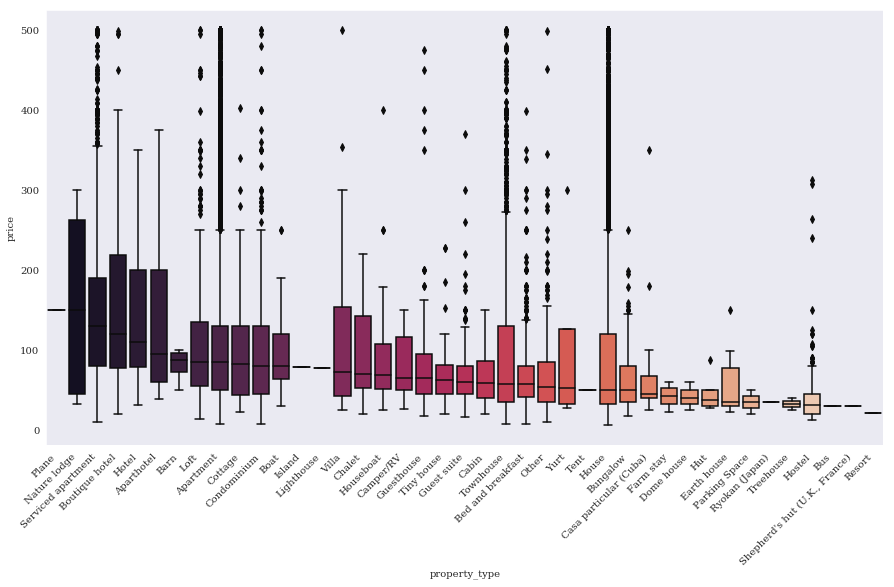

In [30]:
price_per_propertyType = preferred_listing.groupby('property_type')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='property_type', y='price', data=preferred_listing, order=price_per_propertyType, palette='rocket')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In general, *<span style="color:green">Serviced Apartments</span>* seem to be quite a winner!

Intuitive next comparision seems to be of **<span style="color:brown">Room Type against median price</span>**, so let's check that: 

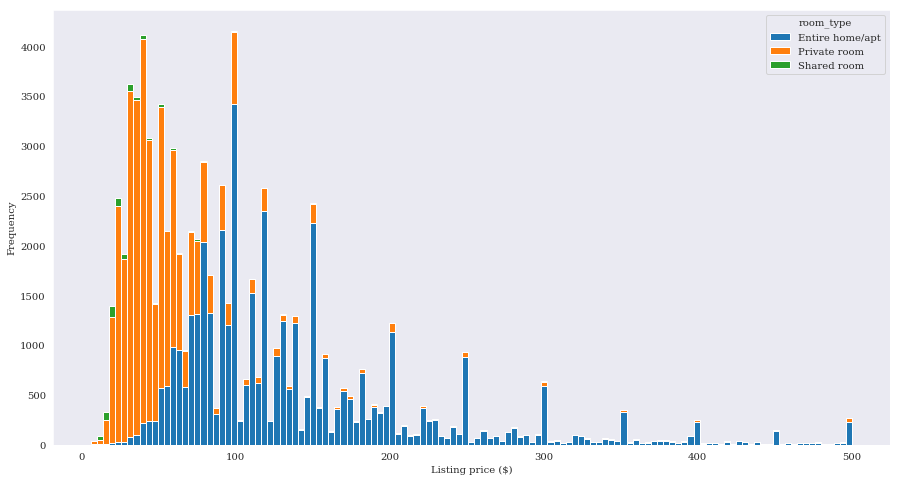

In [31]:
preferred_listing.pivot(columns='room_type', values='price').plot.hist(stacked = True, bins=125)
plt.xlabel('Listing price ($)')
plt.show()

Needless to say that an entire room/apartment will have much higher median price proportion than the other rooms. Generally such property don't even have owners staying in, or possibly some other reason, so again makes sense.

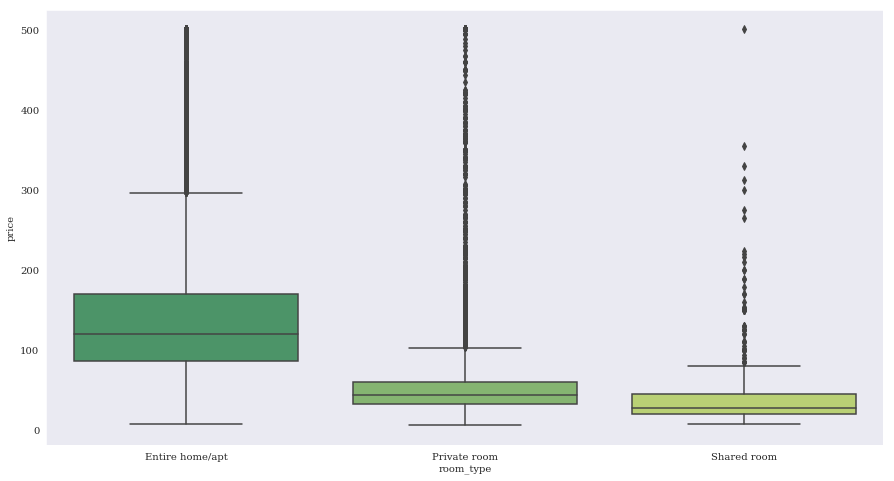

In [32]:
price_per_roomType = preferred_listing.groupby('room_type')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='room_type', y='price', data=preferred_listing, order=price_per_roomType, palette='summer')
plt.show()

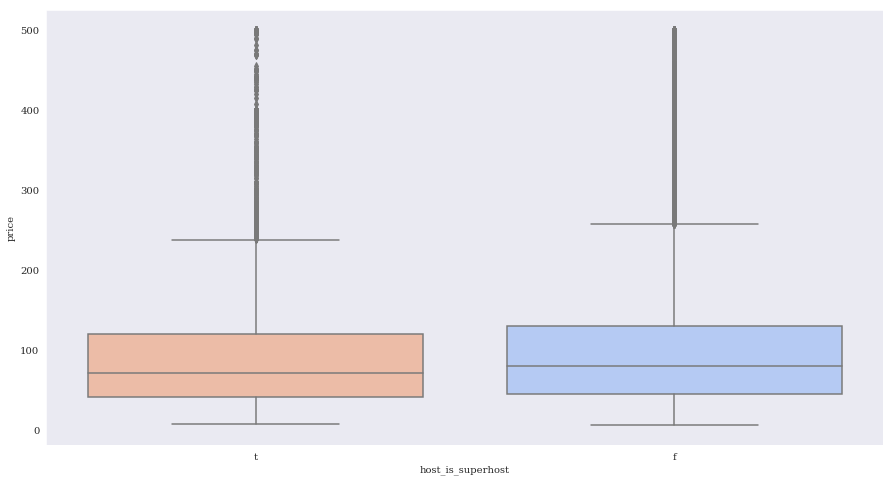

In [33]:
sns.boxplot(x='host_is_superhost', y='price', data=preferred_listing, palette='coolwarm_r')
plt.show()

Next under hood is **<span style="color:green">Bed Type against Price</span>**:

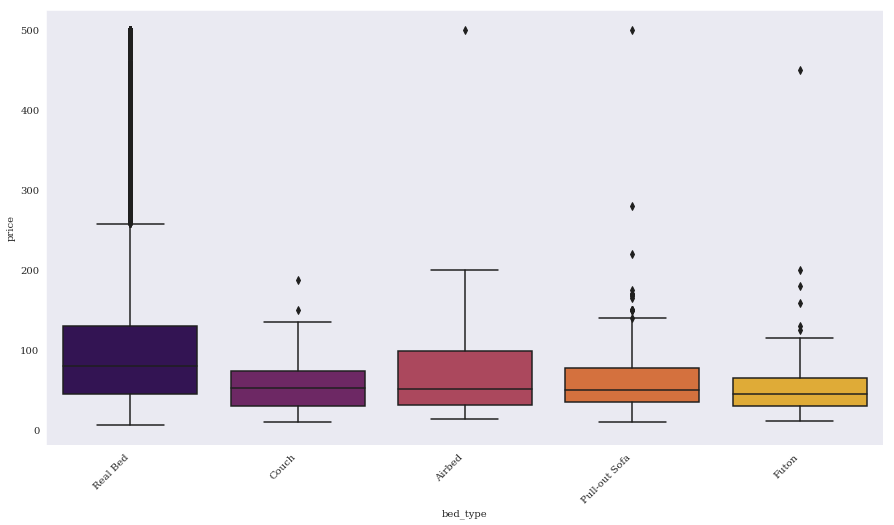

In [34]:
price_per_bedType = preferred_listing.groupby('bed_type')['price'].median().sort_values(ascending=False).index

sns.boxplot(x='bed_type', y='price', data=preferred_listing, order=price_per_bedType, palette='inferno')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

Pretty normal flucuation with Bed types! Next let us dig deeper into **<span style="color:'#d86049'">Amenities</span>** provided: 

In [21]:
# Pulling very first listed property Amenities:
list(listings['amenities'])[0]

'{TV,Internet,Wifi,Kitchen,"Smoking allowed",Breakfast,"Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,"24-hour check-in","Hair dryer","Laptop friendly workspace"}'

In [23]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")
print(list(listings['amenities'])[0])
listings['amenities'].head()

TV,Internet,Wifi,Kitchen,Smoking allowed,Breakfast,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Dryer,Smoke detector,Carbon monoxide detector,Essentials,Shampoo,24-hour check-in,Hair dryer,Laptop friendly workspace


0    TV,Internet,Wifi,Kitchen,Smoking allowed,Break...
1    TV,Cable TV,Wifi,Kitchen,Paid parking off prem...
2    TV,Cable TV,Internet,Wifi,Air conditioning,Kit...
3    TV,Wifi,Kitchen,Paid parking off premises,Elev...
4    TV,Cable TV,Internet,Wifi,Kitchen,Free parking...
Name: amenities, dtype: object

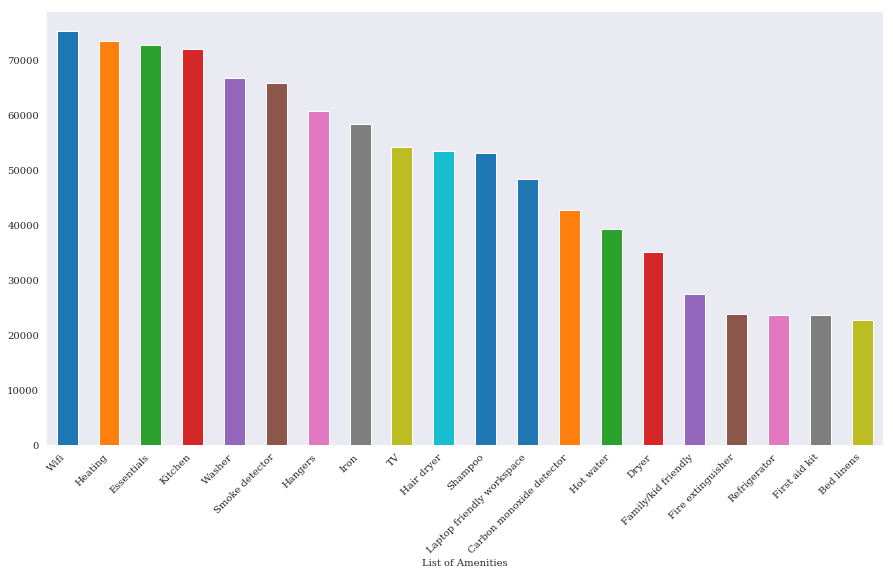

In [39]:
pd.Series(np.concatenate(listings['amenities'].map(lambda x: x.split(',')))).value_counts().head(20).plot(kind='bar')

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('List of Amenities')
plt.show()

Wifi, Heating, Essential, Kitchen and Washer seem to be listed *Top-5 common amenities*.

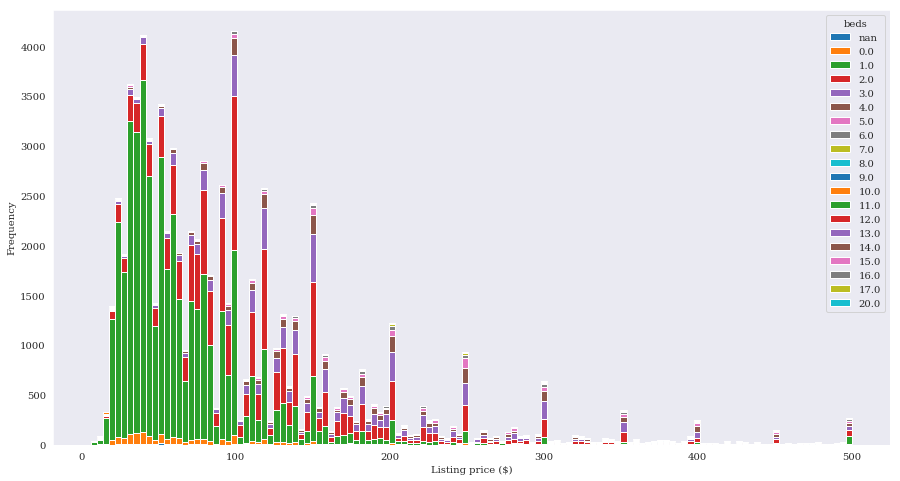

In [41]:
preferred_listing.pivot(columns='beds',values='price').plot.hist(stacked = True,bins=125)
plt.xlabel('Listing price ($)')
plt.show()

Vast majority of the listings have *one bed*, the one-bed listing prices have a very wide range. There are listings that have no bed.

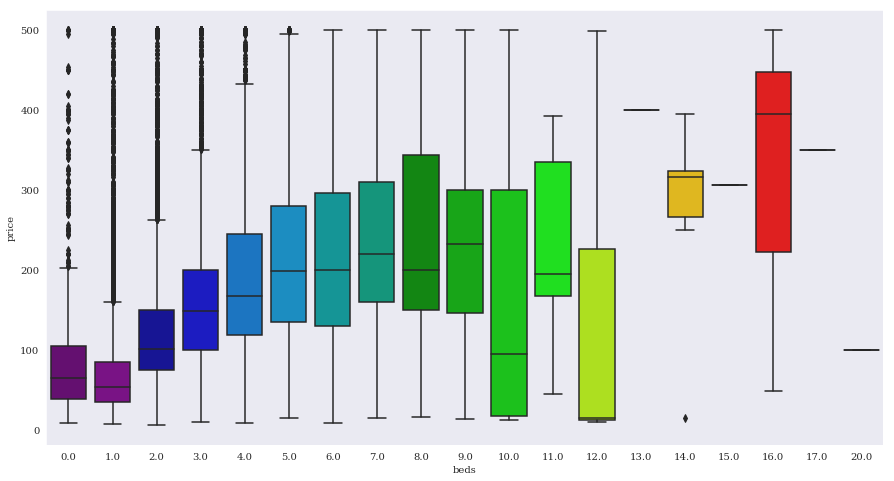

In [43]:
sns.boxplot(y='price', x='beds', data=preferred_listing, palette='nipy_spectral')
plt.show()

Interestingly median price for *No bed* listings is higher than *1-bed* and *2-bed* listings, and median price for *10-bed* listings is very low.

### Quantitative Features:

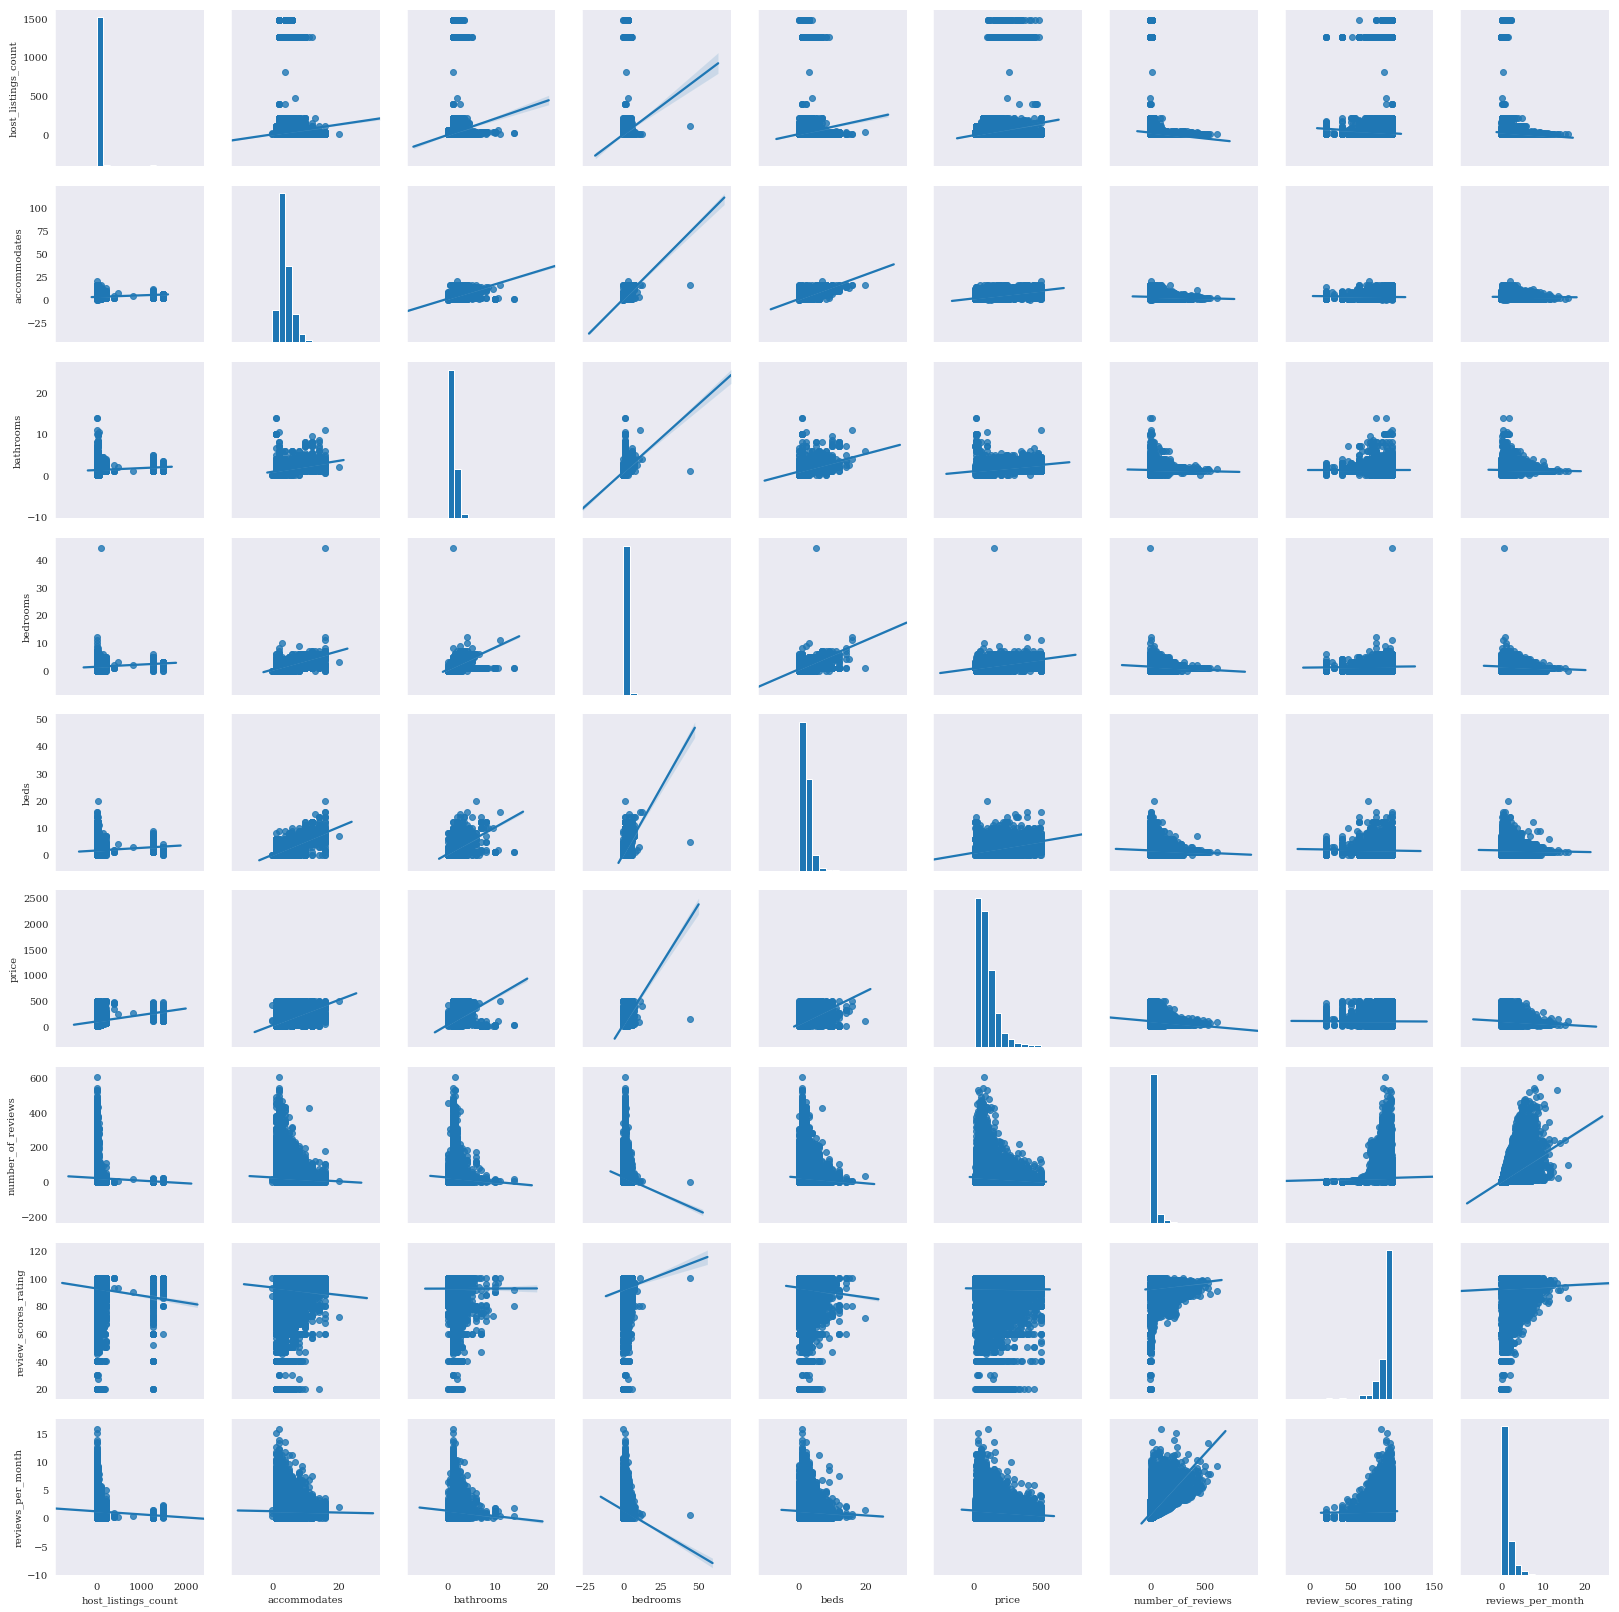

In [45]:
cols = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
       'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']

sns.pairplot(preferred_listing[cols].dropna(), kind='reg', palette='coolwarm')
plt.show()

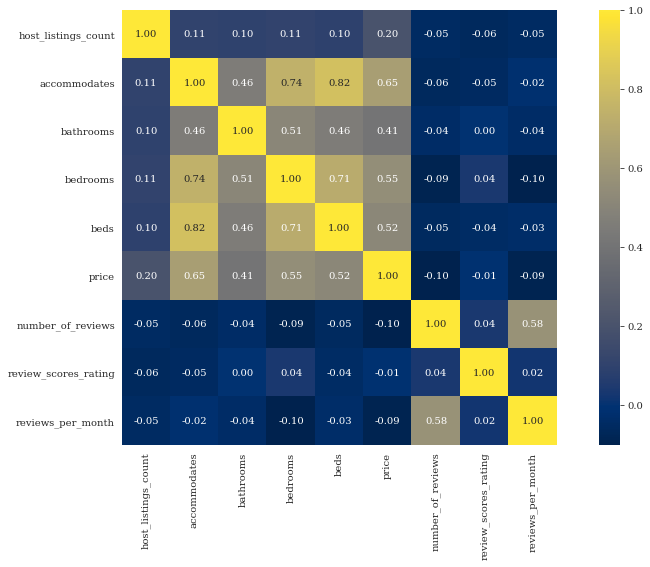

In [48]:
col_corr = preferred_listing[cols].dropna().corr()
sns.heatmap(col_corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=cols, yticklabels=cols, cmap='cividis')
plt.show()

Bedrooms and Accommodates seem to be quite correlated with price.

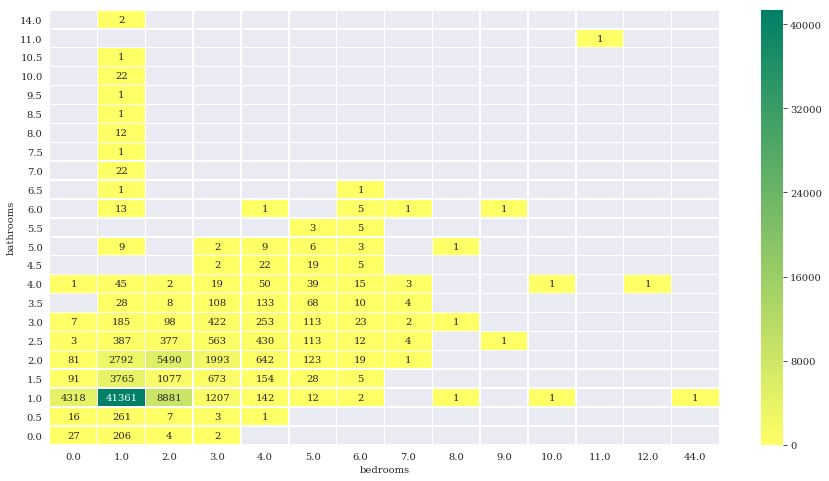

In [51]:
sns.heatmap(preferred_listing.groupby(['bathrooms', 'bedrooms']).count()['price'].reset_index().pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False), 
            cmap='summer_r', fmt='.0f', annot=True, linewidths=0.5)
plt.show()

Vast majority of listings have one bedroom and 1 bathroom.

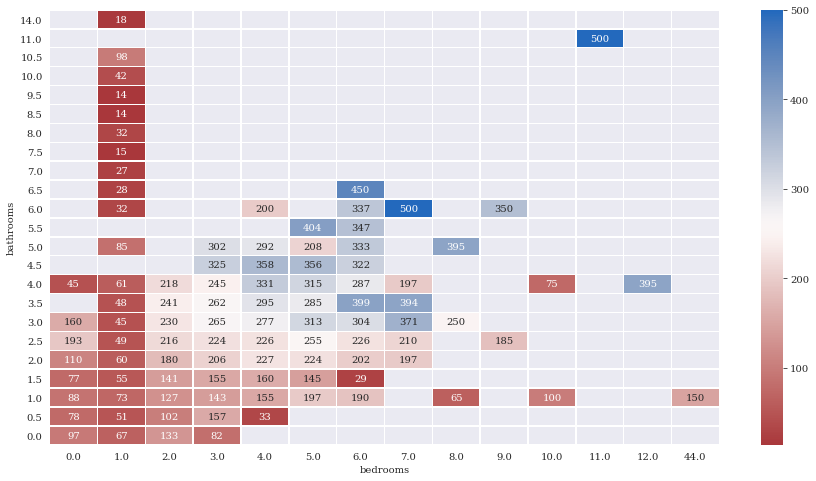

In [53]:
sns.heatmap(preferred_listing.groupby(['bathrooms', 'bedrooms']).mean()['price'].reset_index().pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False),
            cmap='vlag_r', fmt='.0f', annot=True, linewidths=0.5)
plt.show()

It looks like listings with 6 bedrooms and 4 bathrooms have the highest median price. But we must be skeptical about this finding because from the above single graph, we don't know how many listings actually are in this category.

## Exploring Calendar Data:

In [54]:
calendar.date.min(), calendar.date.max()

('2019-02-05', '2020-02-05')

Calendar data covers **one year time frame** so *price* and *availability* every day for the next one year.

In [56]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,9554,2019-02-05,f,$35.00,$35.00,1.0,730.0
1,62260,2019-02-05,t,$50.00,$50.00,1.0,730.0
2,62260,2019-02-06,t,$50.00,$50.00,1.0,730.0
3,62260,2019-02-07,t,$50.00,$50.00,1.0,730.0
4,62260,2019-02-08,t,$50.00,$50.00,1.0,730.0


In [55]:
print(calendar.shape)
calendar.isnull().sum()

(28622069, 7)


listing_id          0
date                0
available           0
price             557
adjusted_price    557
minimum_nights     20
maximum_nights     20
dtype: int64

In this dataset, `f`(false) means **Not available**, `t`(true) means **Available**.

In [57]:
calendar.available.value_counts()

f    19082880
t     9539189
Name: available, dtype: int64

Let us find out daily average availability for one year and before processing, convert **Available** column to `0` if available and `1` if not.

In [58]:
revised_new = calendar[['date', 'available']]
revised_new['busy'] = revised_new.available.map( lambda x: 0 if x == 't' else 1)
revised_new = revised_new.groupby('date')['busy'].mean().reset_index()
revised_new['date'] = pd.to_datetime(revised_new['date'])

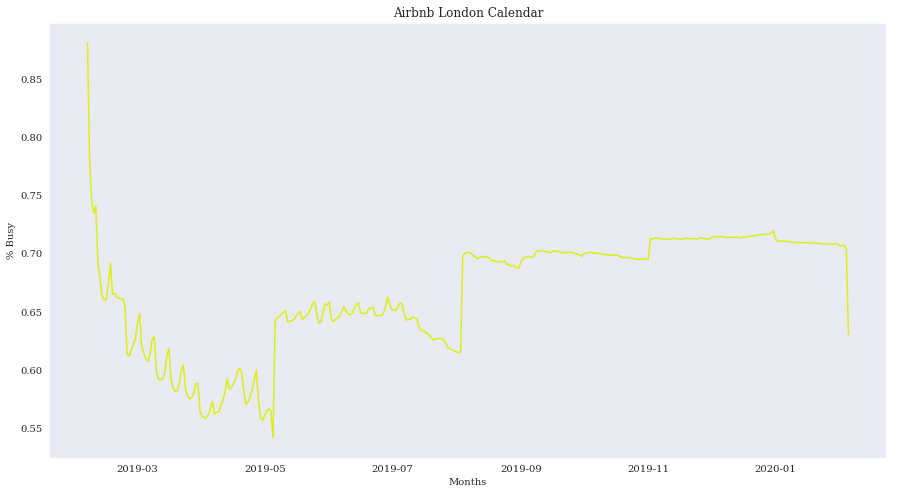

In [61]:
plt.plot(revised_new['date'], revised_new['busy'], color='#daef17')
plt.title('Airbnb London Calendar')
plt.ylabel('% Busy')
plt.xlabel('Months')
plt.show()

The busiest month in London seems October & upcoming busy months seems after August and extend throughout Winter. These are all within our experience and expectations due to events like *Christmas*.

In [62]:
# Preprocessing few columns:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])

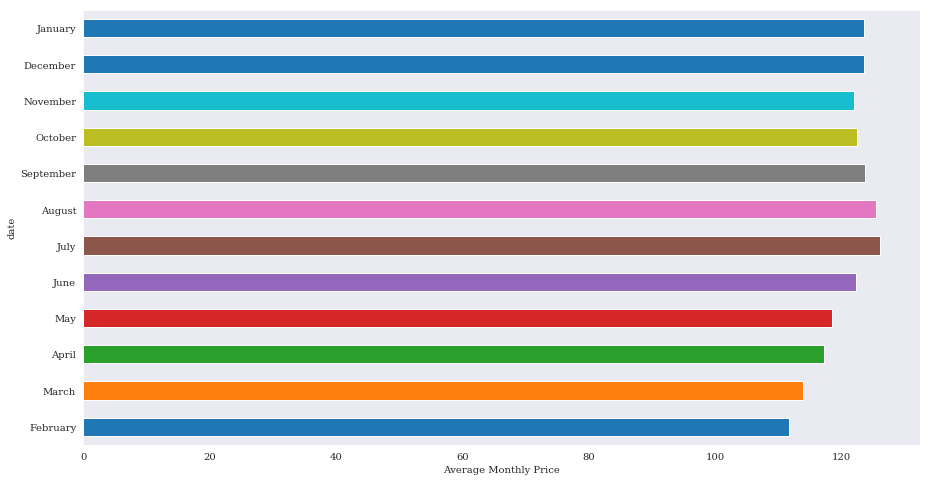

In [63]:
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'), sort=False)['price'].mean()
mean_of_month.plot(kind = 'barh')
plt.xlabel('Average Monthly Price')
plt.show()

Seems core Winter months like *December* and *January* along with mid-Summer in *July* face traffic.